In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
matrix_file_name = 'matrix_3_1997_11.csv'
file = 'GLO3k1p119p_i.csv'
df_all = pd.read_csv(file, low_memory=False)

In [3]:
df_all = df_all.astype({'data_godzina': 'datetime64[ns]'})

In [9]:
df_all

,vote_id,data_godzina,Nrleg,NazwiskoImie,Glos,Klub
0,3001001,1997-10-20 12:51:54,1,Adamczyk Franciszek,Za,AWS
1,3001001,1997-10-20 12:51:54,2,Adamska-Wedler Elżbieta,Za,AWS
2,3001001,1997-10-20 12:51:54,3,Adamski Władysław,Za,SLD
3,3001001,1997-10-20 12:51:54,4,Ajchler Romuald,Za,SLD
4,3001001,1997-10-20 12:51:54,5,Anusz Andrzej,Za,AWS
...,...,...,...,...,...,...
5427086,3119055,2001-09-18 16:26:05,456,Żak Piotr,Za,niez.
5427087,3119055,2001-09-18 16:26:05,457,Żelazowski Andrzej,Za,SLD
5427088,3119055,2001-09-18 16:26:05,458,Żelichowski Stanisław,Nieobecny,PSL
5427089,3119055,2001-09-18 16:26:05,460,Żyliński Adam Jacek,Nieobecny,UW


In [76]:
df = df_all[(df_all['data_godzina'].dt.month == 11) & (df_all['data_godzina'].dt.year == 1997)]

In [77]:
df

,vote_id,data_godzina,Nrleg,NazwiskoImie,Glos,Klub
15180,3001034,1997-11-05 09:08:54,1,Adamczyk Franciszek,Za,AWS
15181,3001034,1997-11-05 09:08:54,2,Adamska-Wedler Elżbieta,Za,AWS
15182,3001034,1997-11-05 09:08:54,3,Adamski Władysław,Za,SLD
15183,3001034,1997-11-05 09:08:54,4,Ajchler Romuald,Za,SLD
15184,3001034,1997-11-05 09:08:54,5,Anusz Andrzej,Za,AWS
...,...,...,...,...,...,...
30355,3003022,1997-11-20 18:42:17,456,Żak Piotr,Za,AWS
30356,3003022,1997-11-20 18:42:17,457,Żelazowski Andrzej,Za,SLD
30357,3003022,1997-11-20 18:42:17,458,Żelichowski Stanisław,Nieobecny,PSL
30358,3003022,1997-11-20 18:42:17,459,Żurek Bogdan,Za,AWS


## Simple data validation

In [78]:
assert np.all(df.dtypes.values == [np.dtype('int64'), np.dtype('<M8[ns]'), np.dtype('int64'), np.dtype('O'), np.dtype('O'), np.dtype('O')])

In [79]:
assert df.isnull().sum().sum() == 0

In [80]:
assert df[df.duplicated()].size == 0

## Assign node ID 
### Handling deputies swaps

In [81]:
# helper functions

def create_deputy_df(df):
    df_deputies = df[['Nrleg', 'NazwiskoImie', 'Klub']]
    df_deputies = df_deputies.groupby(['Nrleg', 'NazwiskoImie'])['Klub'].agg(['unique']).reset_index().rename(columns={"unique": "Klub"})
    return df_deputies

def make_queues(df_deputies, vote_ids, deputy_ids_per_vote):
    removed_ids = []
    new_ids = []

    for i in range(1, len(vote_ids)):
        ids_0 = deputy_ids_per_vote[i-1]
        ids_1 = deputy_ids_per_vote[i]

        removed = set(ids_0).difference(ids_1)
        new = set(ids_1).difference(ids_0)

        if len(removed) > 0:
            for idd in removed:
                r = (idd, list(df_deputies[df_deputies['Nrleg'] == idd]['Klub'].values[0]), vote_ids[i])
                removed_ids.append(r)
        if len(new) > 0:
            for idd in new:
                n = (idd, list(df_deputies[df_deputies['Nrleg'] == idd]['Klub'].values[0]), vote_ids[i])
                new_ids.append(n)
    return removed_ids, new_ids

def find_pairs(removed_ids, new_ids):
    ids_pairs = []
    node_id_dict = {i:i for i in range(1, 461)}

    while len(removed_ids) > 0:
        r_id, r_c, r_v_id = removed_ids.pop(0)
        search = 1
        i = 0
        while search and i < len(new_ids):
            n_id, n_c, n_v_id = new_ids[i]
            if len(set(r_c).intersection(set(n_c))) > 0 and r_v_id <= n_v_id:
                ids_pairs.append((r_id, n_id))
                node_id_dict[n_id] = r_id
                new_ids.pop(i)
                search = 0
            i += 1
    return node_id_dict

In [82]:
def assign_node_ids(df):
    df_deputies = create_deputy_df(df)
    
    vote_ids = sorted(df['vote_id'].unique())
    deputy_ids_per_vote = [df[df['vote_id'] == vote_id]['Nrleg'].unique() for vote_id in vote_ids]
    
    removed_ids, new_ids = make_queues(df_deputies, vote_ids, deputy_ids_per_vote)
    node_id_dict = find_pairs(removed_ids, new_ids)
    
    node_id_dict_func = lambda x: node_id_dict[x]
    node_id_dict_func = np.vectorize(node_id_dict_func)
    
    df_deputies['node_id'] = node_id_dict_func(df_deputies['Nrleg'])
    df_deputies['node_id'] = df_deputies['node_id'] - 1
        
    return df_deputies

In [86]:
df_deputies = assign_node_ids(df)
df = pd.merge(df[['vote_id', 'data_godzina', 'Nrleg', 'NazwiskoImie', 'Glos', 'Klub']], df_deputies[['Nrleg', 'NazwiskoImie', 'node_id']], on=['Nrleg', 'NazwiskoImie'], how='left')

In [18]:
df

,vote_id,data_godzina,Nrleg,NazwiskoImie,Glos,Klub,node_id
0,3001034,1997-11-05 09:08:54,1,Adamczyk Franciszek,Za,AWS,0
1,3001034,1997-11-05 09:08:54,2,Adamska-Wedler Elżbieta,Za,AWS,1
2,3001034,1997-11-05 09:08:54,3,Adamski Władysław,Za,SLD,2
3,3001034,1997-11-05 09:08:54,4,Ajchler Romuald,Za,SLD,3
4,3001034,1997-11-05 09:08:54,5,Anusz Andrzej,Za,AWS,4
...,...,...,...,...,...,...,...
15175,3003022,1997-11-20 18:42:17,456,Żak Piotr,Za,AWS,455
15176,3003022,1997-11-20 18:42:17,457,Żelazowski Andrzej,Za,SLD,456
15177,3003022,1997-11-20 18:42:17,458,Żelichowski Stanisław,Nieobecny,PSL,457
15178,3003022,1997-11-20 18:42:17,459,Żurek Bogdan,Za,AWS,458


## Assign attributes to each node

In [19]:
df_node_atr = df.groupby('node_id').agg({'Nrleg': 'unique',
                                         'NazwiskoImie': pd.Series.unique, 
                                         'Klub': pd.Series.unique})
df_node_atr

,Nrleg,NazwiskoImie,Klub
node_id,,,
0,[1],[Adamczyk Franciszek],[AWS]
1,[2],[Adamska-Wedler Elżbieta],[AWS]
2,[3],[Adamski Władysław],[SLD]
3,[4],[Ajchler Romuald],[SLD]
4,[5],[Anusz Andrzej],[AWS]
...,...,...,...
455,[456],[Żak Piotr],[AWS]
456,[457],[Żelazowski Andrzej],[SLD]
457,[458],[Żelichowski Stanisław],[PSL]


Each node can be assigned to multiple deputies (so 'Nrleg' and 'NazwiskoImie' are lists), party assigned to the node is also a list because deputies can change parties (example below), but we would like to have only one party per node. What can be done? 

1. **Recalculate graph each time a deputy changes a party** (or just make **new a graph for each session** (I hope there are no changes of party between votings from one session) - in the paper the graph is recalculated monthly.

2. **Assign the party from the last voting in the considered period** (we lose some information, but party change is probably not so frequent event, so maybe we shouldn't care).


For now I decided to use the second option.

In [31]:
df['data_godzina'].dt.day.unique()  # 6 sessions in 11.1997

array([ 5,  6, 10, 11, 19, 20], dtype=int64)

In [28]:
df_node_atr[df_node_atr['Klub'].apply(len) > 1]  # he change the party

,Nrleg,NazwiskoImie,Klub
node_id,,,
73,[74],[Dorn Ludwik],"[AWS, niez.]"


In [29]:
df[df['Nrleg'] == 74]

,vote_id,data_godzina,Nrleg,NazwiskoImie,Glos,Klub,node_id
73,3001034,1997-11-05 09:08:54,74,Dorn Ludwik,Nieobecny,AWS,73
533,3001035,1997-11-05 09:36:53,74,Dorn Ludwik,Za,AWS,73
993,3001036,1997-11-05 09:38:02,74,Dorn Ludwik,Za,AWS,73
1453,3001037,1997-11-06 12:12:47,74,Dorn Ludwik,Nie oddał głosu,AWS,73
1913,3001038,1997-11-06 12:13:39,74,Dorn Ludwik,Nie oddał głosu,AWS,73
2373,3002001,1997-11-10 09:06:16,74,Dorn Ludwik,Nieobecny,AWS,73
2833,3002002,1997-11-10 10:02:29,74,Dorn Ludwik,Za,AWS,73
3293,3002003,1997-11-11 00:28:39,74,Dorn Ludwik,Wstrzymał się,AWS,73
3753,3002004,1997-11-11 00:31:29,74,Dorn Ludwik,Przeciw,AWS,73
4213,3002005,1997-11-11 00:32:12,74,Dorn Ludwik,Za,AWS,73


In [35]:
df_node_atr['Klub'] = df_node_atr['Klub'].apply(lambda x: x[-1])

In [36]:
df_node_atr

,Nrleg,NazwiskoImie,Klub
node_id,,,
0,[1],[Adamczyk Franciszek],AWS
1,[2],[Adamska-Wedler Elżbieta],AWS
2,[3],[Adamski Władysław],SLD
3,[4],[Ajchler Romuald],SLD
4,[5],[Anusz Andrzej],AWS
...,...,...,...
455,[456],[Żak Piotr],AWS
456,[457],[Żelazowski Andrzej],SLD
457,[458],[Żelichowski Stanisław],PSL


## Calulating edge weights

"As the first step in our methodology we construct a graph where **each node represents one of the deputies** and **edges are drawn every time two deputies display the same voting behavior (i.e. both vote in favor, against or abstain from vote. No edges are drawn for absent deputies)**. We then normalize edges by the total number of votes in the reference period in order to obtain a weighted graph where weights are . Full weight is given to two deputies  if they participated in all sessions and voted exactly the same way in all of sessions. When a deputy quits the parliament, because of incompatibility, resignation etc., and his or her seat is taken by a new person, we consider the two deputies as being just one node (we check whether this transition leads to some votes in which none of the two deputies had their chairs without finding any discontinuity)."

In [35]:
# czym się różni 'Nie oddał głosu' od 'Wstrzymał się' ?!
df['Glos'].unique()

array(['Za', 'Nieobecny', 'Nie oddał głosu', 'Wstrzymał się', 'Przeciw'],
      dtype=object)

In [36]:
def egde_weights(df):
    """Returns matrix with edge values."""
    common_votes = np.zeros((460, 460))
    vote_ids = df['vote_id'].unique()
    
    for vote_id in tqdm(vote_ids):
        dep_yes = df[(df['vote_id'] == vote_id) & (df['Glos'] == 'Za')]['node_id'].values
        dep_no = df[(df['vote_id'] == vote_id) & (df['Glos'] == 'Przeciw')]['node_id'].values
        dep_abstain = df[(df['vote_id'] == vote_id) & ((df['Glos'] == 'Wstrzymał się') | (df['Glos'] == 'Nie oddał głosu'))]['node_id'].values
        # dep_absent = df[(df['vote_id'] == vote_id) & (df['Glos'] == 'Nieobecny')]['node_id'].values

        # votes in favor
        for i in range(len(dep_yes)):
            for j in range(i+1, len(dep_yes)):
                common_votes[dep_yes[i], dep_yes[j]] += 1
                # common_votes[dep_yes[j], dep_yes[i]] += 1

        # votes in against
        for i in range(len(dep_no)):
            for j in range(i+1, len(dep_no)):
                common_votes[dep_no[i], dep_no[j]] += 1
                # common_votes[dep_no[j], dep_no[i]] += 1

        # abstain from vote
        for i in range(len(dep_abstain)):
            for j in range(i+1, len(dep_abstain)):
                common_votes[dep_abstain[i], dep_abstain[j]] += 1
                # common_votes[dep_abstain[j], dep_abstain[i]] += 1

    return common_votes / len(vote_ids)

In [37]:
edge_matrix = egde_weights(df)

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 18.48it/s]


In [5]:
edge_matrix

array([[0.        , 0.90909091, 0.66666667, ..., 0.24242424, 0.90909091,
        0.87878788],
       [0.        , 0.        , 0.6969697 , ..., 0.24242424, 0.93939394,
        0.90909091],
       [0.        , 0.        , 0.        , ..., 0.36363636, 0.63636364,
        0.6969697 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.21212121,
        0.27272727],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.90909091],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [38]:
np.allclose(edge_matrix, np.triu(edge_matrix)) # upper triangular matrix

True

In [44]:
np.savetxt(matrix_file_name, edge_matrix, delimiter=",")

In [4]:
edge_matrix = np.loadtxt(matrix_file_name, delimiter=",")

## Create graph

In [37]:
G = nx.from_numpy_array(edge_matrix)

In [38]:
A = nx.adjacency_matrix(G)
# print(A.todense())

[[0.         0.90909091 0.66666667 ... 0.24242424 0.90909091 0.87878788]
 [0.90909091 0.         0.6969697  ... 0.24242424 0.93939394 0.90909091]
 [0.66666667 0.6969697  0.         ... 0.36363636 0.63636364 0.6969697 ]
 ...
 [0.24242424 0.24242424 0.36363636 ... 0.         0.21212121 0.27272727]
 [0.90909091 0.93939394 0.63636364 ... 0.21212121 0.         0.90909091]
 [0.87878788 0.90909091 0.6969697  ... 0.27272727 0.90909091 0.        ]]


In [58]:
for n1, n2, e_weight in G.edges.data('weight'):
    G.edges[n1, n2]['distance'] = 1 / e_weight

In [59]:
list(G.edges(data=True))

[(0, 1, {'weight': 0.9090909090909091, 'distance': 1.1}),
 (0, 2, {'weight': 0.6666666666666666, 'distance': 1.5}),
 (0, 3, {'weight': 0.6666666666666666, 'distance': 1.5}),
 (0, 4, {'weight': 0.9393939393939394, 'distance': 1.064516129032258}),
 (0, 5, {'weight': 0.9393939393939394, 'distance': 1.064516129032258}),
 (0, 6, {'weight': 0.9393939393939394, 'distance': 1.064516129032258}),
 (0, 7, {'weight': 0.5757575757575758, 'distance': 1.7368421052631577}),
 (0, 8, {'weight': 0.9090909090909091, 'distance': 1.1}),
 (0, 9, {'weight': 0.9090909090909091, 'distance': 1.1}),
 (0, 10, {'weight': 0.21212121212121213, 'distance': 4.714285714285714}),
 (0, 11, {'weight': 0.6363636363636364, 'distance': 1.5714285714285714}),
 (0, 12, {'weight': 0.6363636363636364, 'distance': 1.5714285714285714}),
 (0, 13, {'weight': 0.9393939393939394, 'distance': 1.064516129032258}),
 (0, 14, {'weight': 0.9393939393939394, 'distance': 1.064516129032258}),
 (0, 15, {'weight': 0.8787878787878788, 'distance': 1

In [42]:
for i in range(len(df_node_atr)):
    nr_leg, name, party = df_node_atr.iloc[i]
    G.nodes[i]['deputy_num'] = list(nr_leg)
    G.nodes[i]['name'] = list(name)
    G.nodes[i]['party'] = party

In [43]:
G.nodes.data()

NodeDataView({0: {'deputy_num': [1], 'name': ['Adamczyk Franciszek'], 'party': 'AWS'}, 1: {'deputy_num': [2], 'name': ['Adamska-Wedler Elżbieta'], 'party': 'AWS'}, 2: {'deputy_num': [3], 'name': ['Adamski Władysław'], 'party': 'SLD'}, 3: {'deputy_num': [4], 'name': ['Ajchler Romuald'], 'party': 'SLD'}, 4: {'deputy_num': [5], 'name': ['Anusz Andrzej'], 'party': 'AWS'}, 5: {'deputy_num': [6], 'name': ['Anuszkiewicz Krzysztof'], 'party': 'AWS'}, 6: {'deputy_num': [7], 'name': ['Arciszewska-Mielewczyk Dorota'], 'party': 'AWS'}, 7: {'deputy_num': [8], 'name': ['Arkuszewski Wojciech'], 'party': 'AWS'}, 8: {'deputy_num': [9], 'name': ['Arndt Paweł'], 'party': 'AWS'}, 9: {'deputy_num': [10], 'name': ['Balazs Artur'], 'party': 'AWS'}, 10: {'deputy_num': [11], 'name': ['Balcerowicz Leszek'], 'party': 'UW'}, 11: {'deputy_num': [12], 'name': ['Banach Jolanta'], 'party': 'SLD'}, 12: {'deputy_num': [13], 'name': ['Bańkowska Anna'], 'party': 'SLD'}, 13: {'deputy_num': [14], 'name': ['Barczyk Kazimier

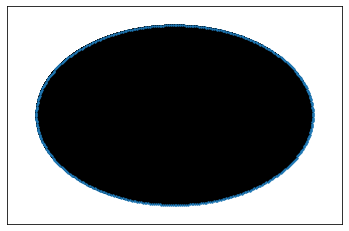

In [135]:
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=2)
nx.draw_networkx_edges(G, pos, arrows=False)
plt.show()

TO DO:
- calculate first measure
- nice network plot
- read the 3 papers 